<a href="https://colab.research.google.com/github/yash3090/CS4641-ML-Project/blob/main/projectCode/MLTeam13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Resources
https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb#scrollTo=aW132I-rbJXE

https://www.tensorflow.org/datasets/catalog/nsynth

## Installation

In [ ]:
pip install tensorflow-datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import librosa as lb

import tensorflow_datasets as tfds

## Find available datasets

All dataset builders are subclass of `tfds.core.DatasetBuilder`. To get the list of available builders, use `tfds.list_builders()` or look at our [catalog](https://www.tensorflow.org/datasets/catalog/overview).

In [ ]:
# tfds.list_builders()

## Load a dataset

### tfds.load

The easiest way of loading a dataset is `tfds.load`. It will:

1. Download the data and save it as [`tfrecord`](https://www.tensorflow.org/tutorials/load_data/tfrecord) files.
2. Load the `tfrecord` and create the `tf.data.Dataset`.


In [ ]:
#this downloads the whole dataset (training, testing, and validation and then only loads the training. When the others are needed, they should be able to be just loaded rather than downloaded again)
# If you encounter not enough memory, disconnect and delete the runtime and try again.
train_ds = tfds.load('nsynth', split='train', shuffle_files=True)
assert isinstance(train_ds, tf.data.Dataset)
test_ds, info = tfds.load('nsynth', split='test', shuffle_files=True, with_info=True)
assert isinstance(test_ds, tf.data.Dataset)

print(train_ds)

#<_PrefetchDataset element_spec={'audio': TensorSpec(shape=(64000,), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'instrument': {'family': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'source': TensorSpec(shape=(), dtype=tf.int64, name=None)}, 'pitch': TensorSpec(shape=(), dtype=tf.int64, name=None), 'qualities': {'bright': TensorSpec(shape=(), dtype=tf.bool, name=None), 'dark': TensorSpec(shape=(), dtype=tf.bool, name=None), 'distortion': TensorSpec(shape=(), dtype=tf.bool, name=None), 'fast_decay': TensorSpec(shape=(), dtype=tf.bool, name=None), 'long_release': TensorSpec(shape=(), dtype=tf.bool, name=None), 'multiphonic': TensorSpec(shape=(), dtype=tf.bool, name=None), 'nonlinear_env': TensorSpec(shape=(), dtype=tf.bool, name=None), 'percussive': TensorSpec(shape=(), dtype=tf.bool, name=None), 'reverb': TensorSpec(shape=(), dtype=tf.bool, name=None), 'tempo-synced': TensorSpec(shape=(), dtype=tf.bool, name=None)}, 'velocity': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

Dl Completed...:   0%|          | 0/1069 [00:00<?, ? file/s]

Dataset nsynth downloaded and prepared to /root/tensorflow_datasets/nsynth/full/2.3.3. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec={'audio': TensorSpec(shape=(64000,), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'instrument': {'family': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'source': TensorSpec(shape=(), dtype=tf.int64, name=None)}, 'pitch': TensorSpec(shape=(), dtype=tf.int64, name=None), 'qualities': {'bright': TensorSpec(shape=(), dtype=tf.bool, name=None), 'dark': TensorSpec(shape=(), dtype=tf.bool, name=None), 'distortion': TensorSpec(shape=(), dtype=tf.bool, name=None), 'fast_decay': TensorSpec(shape=(), dtype=tf.bool, name=None), 'long_release': TensorSpec(shape=(), dtype=tf.bool, name=None), 'multiphonic': TensorSpec(shape=(), dtype=tf.bool, name=None), 'nonlinear_env': TensorSpec(shape=(), dtype=tf.bool, name=None), 'percussive': TensorSpec(s

##Manipulate Entries

(64000,)
tf.Tensor(638, shape=(), dtype=int64)


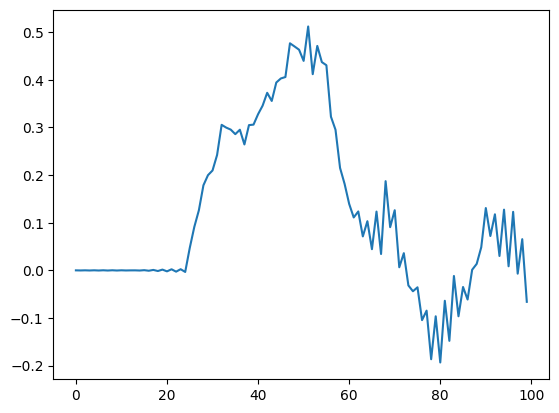

In [ ]:
#TESTING

# first_entry = train_ds.take(1) #gets only the first entry

# for entry in first_entry: #this is a dumb loop, but it exists bc the tf.data.Dataset object contains a dict of tf.Tensors

#   audio = entry["audio"]
#   print(audio.shape)
#   # print(audio[:100])
#   plt.plot(audio[:100].numpy())
#   print(entry["instrument"]["label"])

In [ ]:
#Keshav and Matthew's attempt at building a model that has the waveform as an
#input
SAMPLE_LENGTH = 64000
NUM_CLASSIFICATIONS = 11

model = models.Sequential()
model.add(layers.Input(shape=(SAMPLE_LENGTH, 1)))
model.add(layers.Conv1D(8, kernel_size=3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASSIFICATIONS, activation='softmax'))
model.compile(optimizer="adam", loss='categorical_crossentropy', run_eagerly=True)


model.summary()




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 63998, 8)          32        
                                                                 
 flatten_3 (Flatten)         (None, 511984)            0         
                                                                 
 dense_5 (Dense)             (None, 11)                5631835   
                                                                 
Total params: 5631867 (21.48 MB)
Trainable params: 5631867 (21.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def calculate_true_positives(confusion_matrix, class_index):
    # Sum all values in the confusion matrix except for the given class (row and column)
    tp = confusion_matrix[class_index, class_index]
    return tp

def calculate_true_negatives(confusion_matrix, class_index):
    # Sum all values in the confusion matrix except for the given class (row and column)
    tn = np.sum(confusion_matrix) - np.sum(confusion_matrix[class_index, :]) - np.sum(confusion_matrix[:, class_index]) + confusion_matrix[class_index, class_index]
    return tn

def calculate_false_positives(confusionMatrix, class_index):
    # Sum the values in the predicted class column excluding the diagonal element (True Positive)
    falsePositive = np.sum(confusionMatrix[:, class_index]) - confusionMatrix[class_index, class_index]
    return falsePositive

def calculate_false_negatives(confusionMatrix, class_index):
    # Sum the values in the row (actual class) excluding the diagonal element (True Positive)
    falseNegative = np.sum(confusionMatrix[class_index, :]) - confusionMatrix[class_index, class_index]
    return falseNegative

In [ ]:
# Evaluation Metrix for model performance - Yash
# can do individually for each class, done rn for all together
num_matches = 0
correct_percentages = 0

test_ds, test_info = tfds.load('nsynth', split='test', with_info=True, shuffle_files=True, batch_size=1)

confusionMatrix = np.array([[0 for _ in range(11)] for _ in range(11)])
numTestSamples = 100
for batch in test_ds.take(numTestSamples): # 100 test samples
    sample_audio = batch["audio"]#Audio array
    label = batch['instrument']['family'].numpy()#Ground truth instrument label
    #print("Ground truth: ", label)

    # Reshape the audio data
    sample_audio = tf.reshape(sample_audio, (-1, SAMPLE_LENGTH, 1))

    #Has the model been trained at this point?
    # Don't you need something like this
    # model.fit(sample_audio, label, epochs=10) #use training data and labels
    # test_loss, test_acc = model.evaluate(test_audio,  test_labels, verbose=2)
    predictions = model.predict(sample_audio, verbose=False) # Ex: [.21, .31, .11, .01, .90]
    predicted_class = tf.argmax(predictions, axis=1).numpy() # Ex: [.90]
    #print(predicted_class.shape)
    #print(label.shape)

    confusionMatrix[label[0]][predicted_class[0]] += 1
    if label == predicted_class[0]:
     num_matches += 1
     correct_percentages += predictions[:,label][0]


    #print("Predicted: ", predicted_class)

num_classes = 11
print(confusionMatrix)

truePositive = 0
for i in range(num_classes):
  truePositive += calculate_true_positives(confusionMatrix, i)
print("True Positive: ", truePositive)

falseNegative =  0 # The sum of values of corresponding rows except for the TP value
for i in range(num_classes):
  falseNegative += calculate_false_negatives(confusionMatrix, i)
print("False Negative: ", falseNegative)

falsePositive = 0
for i in range(num_classes):
  falsePositive += calculate_false_positives(confusionMatrix, i)
print("False Positive: ", falsePositive)

trueNegative = 0
for i in range(num_classes):
  trueNegative += calculate_true_negatives(confusionMatrix, i)
print("True Negative: ", trueNegative)

accuracy = (truePositive + trueNegative)/(trueNegative + truePositive + falseNegative + falsePositive)
print("Accuracy: ", accuracy)
precision = truePositive/(truePositive + falsePositive)
print("Precision: ", precision)
recall = truePositive/(truePositive + falseNegative)
print("Recall: ", recall)
# True negative rate = specificity
specificity = trueNegative/(trueNegative + falsePositive)
print("Specificity: ", specificity)
f1_score = 2*precision*recall/(precision + recall)
print("F1 Score: ", f1_score)
percentage_correct = num_matches/numTestSamples
print(percentage_correct)
print("Percentage correct prediction: ", percentage_correct) #We are getting over 30-40% accuracy with batch size 10,000


[[ 0  0 10  4  1  0  0  1  0  9  1]
 [ 0  0  0  0  1  0  1  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0]
 [ 2  0  6  1  3  0  2  1  0  1  1]
 [ 1  1  4  3  3  1  2  1  1  1  2]
 [ 0  0  4  1  0  1  0  1  0  0  0]
 [ 1  0  0  3  0  1  0  1  0  3  0]
 [ 0  0  2  1  0  0  1  0  0  0  0]
 [ 1  1  5  1  0  0  1  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  1  0]]
True Positive:  5
False Negative:  95
False Positive:  95
True Negative:  905
Accuracy:  0.8272727272727273
Precision:  0.05
Recall:  0.05
Specificity:  0.905
F1 Score:  0.05000000000000001
0.05
Percentage correct prediction:  0.05


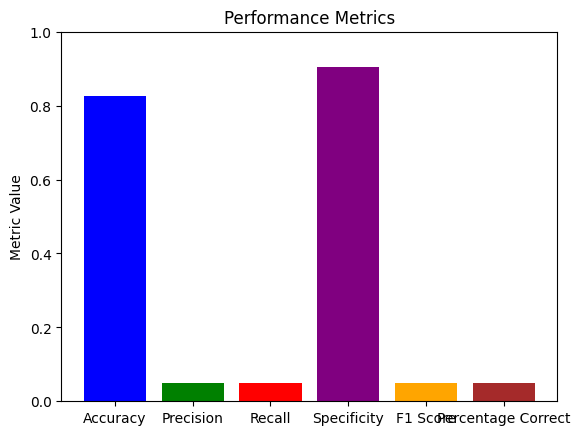

In [ ]:
# Data Visualization
# Metrics names for visualization
metrics_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score', 'Percentage Correct']

# Corresponding metric values
metrics_values = [accuracy, precision, recall, specificity, f1_score, percentage_correct]

# Plotting bar chart
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])
plt.ylim(0, 1)  # Set y-axis range to 0-1 for percentage metrics
plt.title('Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

In [ ]:
# Yash Looking at data processing
# didn't use normalization between [0,1] as different samples have diff max, normalizing all of them between 0 and 1 would maybe skew data.
# instead since current data is between -1 and 1, we divide values by 2 and add 0.5. Keeping data in range 0 to 1
train_ds, train_info = tfds.load('nsynth', split='train', with_info=True, shuffle_files=True, batch_size=1)
data = train_ds.take(1)
# starts being useful/loud from 100
# not useful 50000 after

# can subtract min value in signal to remove noise

for d in data:
  for sample in d["audio"]:
    print(sample[-14000:-10000])
    print(max(sample[-14000:-10000]))
    sample = np.array(sample)/2 + 0.5
    sample = sample[25000:29999]
    print(sample.shape)


tf.Tensor(
[-9.9563954e-07 -2.0430261e-05 -4.2784966e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], shape=(4000,), dtype=float32)
tf.Tensor(0.000121726756, shape=(), dtype=float32)
(4999,)


In [ ]:
#Matthew's Attempt to Train the Model
#model1
train_ds, train_info = tfds.load('nsynth', split='train', with_info=True, shuffle_files=True, batch_size=10000)
test_ds, test_info = tfds.load('nsynth', split='test', with_info=True, shuffle_files=True, batch_size=10)


for batch in train_ds.take(1): # 10000 test samples
    train_sample_audio = batch["audio"] #Audio array
    train_label = batch['instrument']['family'].numpy() #Ground truth instrument label

    train_sample_audio = tf.reshape(train_sample_audio, (-1, SAMPLE_LENGTH, 1))

    # Create a one-hot encoding tensor
    train_label = tf.one_hot(train_label, NUM_CLASSIFICATIONS) # [0, 0, 0,..., 1]
    train_label = tf.reshape(train_label, (-1, NUM_CLASSIFICATIONS))

    print("Sample shape: ", train_sample_audio.shape)
    print("Label shape: ", train_label.shape)

    model.fit(train_sample_audio, train_label, epochs=10) #use training data and labels

#THIS WORKS PERFECTLY, JUST COMMENTING TO SKIP TESTING
# for batch in test_ds.take(1): # 10 test samples
#     test_sample_audio = batch["audio"]#Audio array
#     test_label = batch['instrument']['family'].numpy()#Ground truth instrument label

#     test_sample_audio = tf.reshape(test_sample_audio, (-1, SAMPLE_LENGTH, 1))

#     # Create a one-hot encoding tensor
#     test_label = tf.one_hot(test_label, NUM_CLASSIFICATIONS)
#     test_label = tf.reshape(test_label, (-1, NUM_CLASSIFICATIONS))

#     loss = model.evaluate(test_sample_audio,  test_label, verbose=2)
#     print("Loss: ", loss)


Sample shape:  (10000, 64000, 1)
Label shape:  (10000, 11)
Epoch 1/10
313/313 [==============================] - 217s 691ms/step - loss: 2.4325
Epoch 2/10
313/313 [==============================] - 226s 720ms/step - loss: 1.2742
Epoch 3/10
313/313 [==============================] - 220s 703ms/step - loss: 0.9874
Epoch 4/10
313/313 [==============================] - 229s 730ms/step - loss: 0.8231
Epoch 5/10
313/313 [==============================] - 224s 714ms/step - loss: 0.7040
Epoch 6/10
313/313 [==============================] - 223s 712ms/step - loss: 0.6510
Epoch 7/10
313/313 [==============================] - 229s 731ms/step - loss: 0.5803
Epoch 8/10
313/313 [==============================] - 223s 713ms/step - loss: 0.5309
Epoch 9/10
313/313 [==============================] - 223s 712ms/step - loss: 0.4577
Epoch 10/10
313/313 [==============================] - 228s 730ms/step - loss: 0.5025


#Model 2

In [ ]:
#I believe this is redundant (Matthew)
# train_ds = tfds.load('nsynth', split='train', shuffle_files=True, batch_size=500)
# assert isinstance(train_ds, tf.data.Dataset)
# test_ds, info = tfds.load('nsynth', split='test', shuffle_files=True, with_info=True, batch_size=1)
# assert isinstance(test_ds, tf.data.Dataset)

In [ ]:
#Keshav working on converting an input note into a spectrogram
epsilon = tf.constant(1e-5)
def audio_to_spectrogram(train_sample_audio):
  stft = tf.signal.stft(train_sample_audio, frame_length = 800, frame_step=128, fft_length=800) #Fourrier transform
  stft = tf.abs(stft)
  db_spectrogram = (20 * tf.math.log(stft) / (tf.math.log(10.0)))
  return db_spectrogram + epsilon


Instrument pitch:  tf.Tensor(
[ 65  92  75  80  81  76 106  26  50  34  92  52  54  62  64 103  68  60
  42  78  28  30  36 108  83  47  26  55  81  60  42  69  38  76 103  97
  61  47  24  77  76  44  99  60  72  55  54  48  34  62  86  94  30  59
  61  74  57  53  50  73  75  66  87  69  34  73  48  38  27  85  79  86
  62  75  25 105  47  53  24  65  53  76  40  56  29 102  80  81  48  25
  52 102  26  87  21  51  64  64  39  38  46  52  57  74  59  50  57  48
  82  38  64  68  62  84  44  38  45  74  86  79  76  64  87  54  21  49
  56  53  52  28  70 106  51  91  21  35  52  50  82  89  72  48  75  78
  81  90  73  52  25  83  61  20  95  69  53  48  92  64  71  25  75  65
  60  32  47  45 105  39  82  42  42  74  63  42 104  36  41  33  64  49
  80  74  56  35  31  47  75  48  38  51  95  51  25  49  60  36  56  38
  41  26  28  33  26  85  85  71  61 108  42  97 101  40  65  23  76  37
 104  63  87  58  40  95 108  53  28  66  62  72  78  78  61  56  74  46
  51  62  37  40  43 

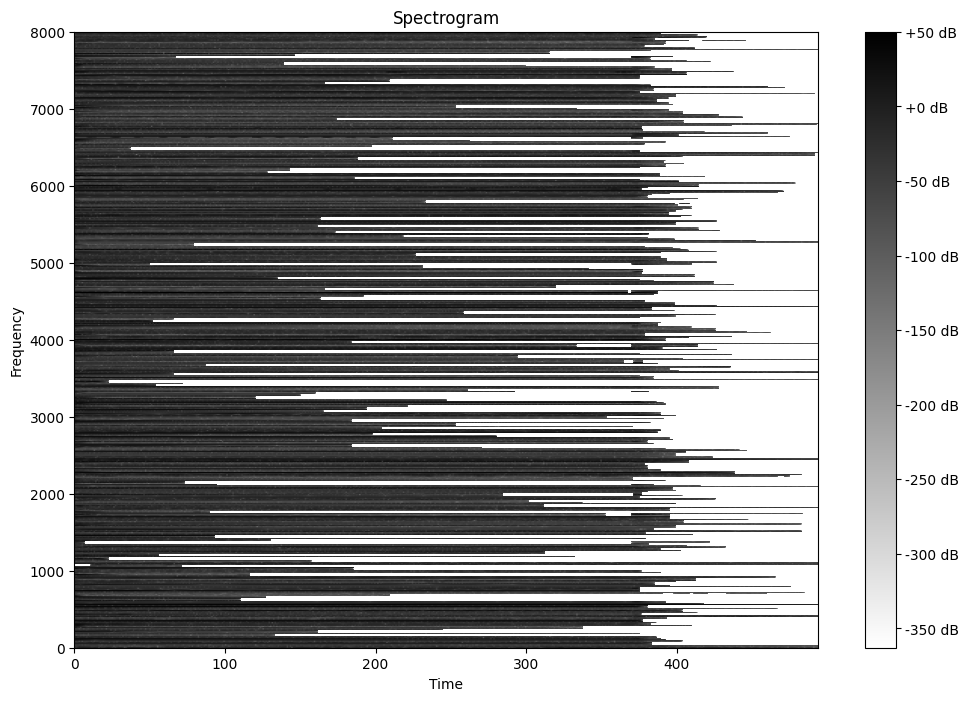

In [ ]:
# # TESTING

# # Keshav's test for spectrogram function
# SAMPLE_RATE = 16000
# for batch in train_ds.take(1):
#    train_sample_audio = batch["audio"]#Audio array
#    db_spectrogram = audio_to_spectrogram(train_sample_audio).numpy() + epsilon

#   #  db_spectrogram = tf.transpose(db_spectrogram).numpy()
#    ground_truth_label = batch["instrument"]["family"]
#    instrument_pitch = batch["pitch"]#Range of pitch on a midi keyboard is 21-108


#    print("Instrument pitch: ", instrument_pitch)
#    print("Ground truth instrument: ", ground_truth_label)#This is just so I can get a good idea of what
#                             #instrument is being processed currently
#    print("spec shape: ", db_spectrogram.shape)
#    plt.figure(figsize=(12, 8))
#    plt.imshow(db_spectrogram[:,:,0], aspect='auto', origin='lower', cmap='gray_r',
#                extent=[0, db_spectrogram.shape[1], 0, SAMPLE_RATE / 2])
#    print(db_spectrogram.shape)
#    #basic plt plot
#    plt.colorbar(format='%+2.0f dB')
#    plt.title('Spectrogram')
#    plt.xlabel('Time')
#    plt.ylabel('Frequency')

#     # Display the plot
#    plt.show()

In [ ]:
from tensorflow.python.training.saver import metrics
#Keshav's attempt at building a network that takes in spectrogram images as an input
#model2
time_bins = 494
freq_bins = 300
num_channels = 1#1 channel because the image is greyscale
input_shape = (time_bins, freq_bins, 1)
NUM_CLASSIFICATIONS = 11

#Keshav's
spec_model = models.Sequential([
    # Convolutional Block 1
    layers.Conv2D(16, (3, 3), padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Convolutional Block 2
    layers.Conv2D(32, (3, 3), padding='same'),  # Increase the number of filters
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flattening and Final Dense Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSIFICATIONS, activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-2,
    decay_steps=10000,
    decay_rate=0.9)

#Matthew's
# spec_model = models.Sequential([
#     layers.Input(shape=input_shape),
#     layers.Conv2D(32, kernel_size=(5, 5), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Dropout(0.25),

#     layers.Conv2D(64, kernel_size=(5, 5), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Dropout(0.25),

#     layers.Conv2D(128, kernel_size=(5, 5), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Dropout(0.25),

#     layers.Flatten(),
#     layers.Dense(NUM_CLASSIFICATIONS, activation='softmax')
# ])


# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     # initial_learning_rate=1e-2,
#     initial_learning_rate=5e-2, #also try flipped to e-2
#     decay_steps=10000,
#     decay_rate=0.9)



optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

spec_model.compile(
    optimizer=optimizer,
    # loss='sparse_categorical_crossentropy',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

spec_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 494, 300, 16)      160       
                                                                 
 batch_normalization_3 (Bat  (None, 494, 300, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                (None, 494, 300, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 247, 150, 16)      0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 247, 150, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 247, 150, 32)     

In [ ]:
train_ds, train_info = tfds.load('nsynth', split='train', with_info=True, shuffle_files=True, batch_size=500)
test_ds, test_info = tfds.load('nsynth', split='test', with_info=True, shuffle_files=True, batch_size=1)


In [ ]:
import tensorflow as tf


# def preprocess(batch):
#     audio = batch["audio"]
#     # audio = tf.convert_to_tensor(audio)/2 + 0.5
#     # audio = audio[25000:29999]
#     spectrogram = audio_to_spectrogram(audio)
#     label = batch["instrument"]["family"]
#     print(spectrogram.shape, label.shape)
#     return spectrogram, label

layer = tf.keras.layers.LayerNormalization()
reduced_features = 300 # num of features it should be reduced too
def preprocess(batch):
    audio = batch["audio"] + epsilon
    spectrogram = audio_to_spectrogram(audio)
    label = batch["instrument"]["family"]

    # Implementing PCA
    input_shape = tf.shape(spectrogram)
    flat_spectrogram = tf.reshape(spectrogram, shape=(-1, input_shape[-1]))
    # Standardize the data??
    # standardized_spectrogram = layer(flat_spectrogram)
    standardized_spectrogram = flat_spectrogram
    # PCA - reducing dimensions
    cov_matrix = tf.linalg.matmul(standardized_spectrogram, standardized_spectrogram, transpose_a=True)
    eigenvalues, eigenvectors = tf.linalg.eigh(cov_matrix)
    reduced_spectrogram = tf.linalg.matmul(standardized_spectrogram, eigenvectors[:, -reduced_features:])
    reduced_spectrogram = tf.reshape(reduced_spectrogram, shape=(input_shape[0], input_shape[1], reduced_features))
    spectrogram = reduced_spectrogram
    print("reduced ", reduced_spectrogram.shape)
    return spectrogram, label

spec_train = train_ds.map(preprocess)
print("spec ", spec_train)
spec_test = test_ds.map(preprocess)





reduced  (None, 494, 300)
spec  <_MapDataset element_spec=(TensorSpec(shape=(None, 494, 300), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
reduced  (None, 494, 300)


In [ ]:
#Test one
# for spectrogram, label in spec_train.take(1):
#     print("Spectrogram shape: ", spectrogram.shape)
#     print("Label shape: ", label.shape)
#     # Optionally visualize the spectrogram or listen to the audio

In [ ]:
# history = spec_model.fit(spec_train, epochs=10, validation_data=spec_test)


Epoch 1/10
 1686/28921 [>.............................] - ETA: 24:11:11 - loss: nan - accuracy: 0.2253

In [ ]:
# # TESTING
# spec_train = spec_train.batch(100)
# # This is a test cell to make sure that the mapping function worked
# for batch in spec_train.take(1):
#    train_sample_audio = batch[0]#Spectrogram
#    print(train_sample_audio.shape)
#    print("Sample audio: ", train_sample_audio)
#    db_spectrogram = tf.transpose(train_sample_audio).numpy()
#    ground_truth_label = batch[1]#label, in this case, instrument family
#   #  instrument_pitch = batch["pitch"]#Range of pitch on a midi keyboard is 21-108


#   #  print("Instrument pitch: ", instrument_pitch)
#    print("Ground truth instrument: ", ground_truth_label)#This is just so I can get a good idea of what
#                             #instrument is being processed currently
#    print("spec shape: ", db_spectrogram.shape)
#    plt.figure(figsize=(12, 8))
#    plt.imshow(db_spectrogram[:,0], aspect='auto', origin='lower', cmap='gray_r',
#                extent=[0, db_spectrogram.shape[1], 0, SAMPLE_RATE / 2])
#    print(db_spectrogram.shape)
#    #basic plt plot
#    plt.colorbar(format='%+2.0f dB')
#    plt.title('Spectrogram')
#    plt.xlabel('Time')
#    plt.ylabel('Frequency')

#     # Display the plot
#    plt.show()


In [ ]:
batch_size = 100
# spec_train = spec_train.batch(batch_size)

# Define the number of epochs for training
epochs = 10

# Fit the model
# history = spec_model.fit(train_dataset, epochs=epochs)
NUM_CLASSIFICATIONS = 11
for batch in spec_train.take(1):
    sample_spec = batch[0]  # spectrogram
    train_label = batch[1]  # Ground truth instrument label
    # print(train_label.shape)

    # Ensure the label is of integer type
    # train_label = tf.cast(train_label, tf.int32)

    # Create a one-hot encoding tensor
    train_label = tf.one_hot(train_label, NUM_CLASSIFICATIONS)
    train_label = tf.reshape(train_label, (-1, NUM_CLASSIFICATIONS))

    print("Sample shape: ", sample_spec.shape)
    print("Label shape: ", train_label.shape)

    # Fit the model
    spec_model.fit(sample_spec, train_label, epochs=10)







(500,)
Sample shape:  (500, 494, 300)
Label shape:  (500, 11)
Epoch 1/10
16/16 [==============================] - 111s 7s/step - loss: 428.7245 - accuracy: 0.0800
Epoch 2/10
16/16 [==============================] - 105s 7s/step - loss: 2.2616 - accuracy: 0.1820
Epoch 3/10
16/16 [==============================] - 95s 6s/step - loss: 2.2015 - accuracy: 0.1820
Epoch 4/10
16/16 [==============================] - 94s 6s/step - loss: 2.1899 - accuracy: 0.2120
Epoch 5/10
16/16 [==============================] - 96s 6s/step - loss: 2.1917 - accuracy: 0.2160
Epoch 6/10
16/16 [==============================] - 94s 6s/step - loss: 2.1904 - accuracy: 0.2160
Epoch 7/10
16/16 [==============================] - 93s 6s/step - loss: 2.1904 - accuracy: 0.2160
Epoch 8/10
16/16 [==============================] - 93s 6s/step - loss: 2.1910 - accuracy: 0.2160
Epoch 9/10
16/16 [==============================] - 106s 7s/step - loss: 2.1923 - accuracy: 0.2160
Epoch 10/10
16/16 [==============================] 

In [ ]:
# Evaluation Matrix for model performance - (redone by Matthew for 2D)
# can do individually for each class, done rn for all together
num_matches = 0
correct_percentages = 0

confusionMatrix = np.zeros((11,11), dtype = int)
numTestSamples = 100
for batch in spec_test.take(numTestSamples): # 100 test samples
    sample_spec = batch[0]#Audio array
    label = batch[1].numpy()#Ground truth instrument label
    label = label[0] #label used to be an array of size 1
    # print("Ground truth: ", label)

    predictions = spec_model.predict(sample_spec, verbose=False) # [.21, .31, .11, .01, .90]
    predicted_class = tf.argmax(predictions, axis=1).numpy() # [.90]
    # print(predicted_class)
    # print(predicted_class[0])

    confusionMatrix[label][predicted_class[0]] += 1
    if label == predicted_class[0]:
     num_matches += 1
     correct_percentages += predictions[:,label][0]


    #print("Predicted: ", predicted_class)

num_classes = 11
print(confusionMatrix)

truePositive = 0
for i in range(num_classes):
  truePositive += calculate_true_positives(confusionMatrix, i)
print("True Positive: ", truePositive)

falseNegative =  0 # The sum of values of corresponding rows except for the TP value
for i in range(num_classes):
  falseNegative += calculate_false_negatives(confusionMatrix, i)
print("False Negative: ", falseNegative)

falsePositive = 0
for i in range(num_classes):
  falsePositive += calculate_false_positives(confusionMatrix, i)
print("False Positive: ", falsePositive)

trueNegative = 0
for i in range(num_classes):
  trueNegative += calculate_true_negatives(confusionMatrix, i)
print("True Negative: ", trueNegative)

accuracy = (truePositive + trueNegative)/(trueNegative + truePositive + falseNegative + falsePositive)
print("Accuracy: ", accuracy)
precision = truePositive/(truePositive + falsePositive)
print("Precision: ", precision)
recall = truePositive/(truePositive + falseNegative)
print("Recall: ", recall)
# True negative rate = specificity
specificity = trueNegative/(trueNegative + falsePositive)
print("Specificity: ", specificity)
f1_score = 2*precision*recall/(precision + recall)
print("F1 Score: ", f1_score)
print(correct_percentages)
print("Percentage correct prediction: ", num_matches/numTestSamples)


NameError: ignored

In [ ]:
SAMPLE_LENGTH = 64000
NUM_CLASSIFICATIONS = 11

for batch in spec_test.take(1): # 10 test samples NEED TO UPDATE ABOVE
    test_sample_audio = batch[0]#Audio array
    test_label = batch[1].numpy()#Ground truth instrument label

    # Create a one-hot encoding tensor
    test_label = tf.one_hot(test_label, NUM_CLASSIFICATIONS)
    test_label = tf.reshape(test_label, (-1, NUM_CLASSIFICATIONS))

    # test_sample_spec = preprocess(test_sample_audio)

    loss = spec_model.evaluate(test_sample_audio,  test_label, verbose=2)
    # loss = spec_model.evaluate(test_sample_spec,  test_label, verbose=2)
    print("Loss: ", loss)

2/2 - 3s - loss: nan - accuracy: 0.2200 - 3s/epoch - 1s/step
Loss:  [nan, 0.2199999988079071]


In [ ]:

# Evaluation Metrix for model performance - Yash
num_matches = 0

for batch in spec_test.take(100): # 100 test samples
    test_audio = batch[0]#Audio array
    label = batch[1]#Ground truth instrument label
    print("Ground truth: ", label)
    print(test_audio.shape)



    #Has the model been trained at this point?
    # Don't you need something like this
    #model.fit(sample_audio, label, epochs=10) #use training data and labels
    #test_loss = model.evaluate(test_audio,  label, verbose=2)
    predictions = spec_model.predict(test_audio, verbose=False)

    predicted_class = tf.argmax(predictions, axis=1).numpy()
    N = len(label)
    if label == predicted_class:#Matthew how did you get this to output correctly?
     num_matches += 1
    print("Predicted: ", predicted_class)



print(num_matches/100)

Ground truth:  tf.Tensor(
[0 8 4 3 4 5 7 3 0 0 4 3 0 0 3 4 3 3 3 8 6 0 0 0 8 8 3 3 4 3 6 0 3 0 1 7 1
 4 4 4 1 1 3 6 6 4 0 3 0 0], shape=(50,), dtype=int64)
(50, 494, 401)


ValueError: ignored